# Aufgabe 1
In dieser Aufgabe geht es darum, Zufallszahlen, die der Planck-Verteilung folgen sollen, (effizient) zu generieren. Zunächst werden einige Dinge berechnet...

In [30]:
import numpy as np
from scipy import optimize
from scipy import integrate
from numpy import random
import matplotlib.pyplot as plt
import timeit

In [31]:
def planck(x):
    return 15/np.pi**4 * x**3/(np.exp(x)-1)


def planckDerivative(x):
    return 15/np.pi**4*x**2 * (3*(np.exp(x)-1)-x*np.exp(x))/(np.exp(x)-1)**2

In [32]:
# Calculating the maximum of the planck distribution
x_max = optimize.brentq(planckDerivative,0.01,10)
y_max = planck(x_max)
print(x_max)
print(y_max)

2.8214393721220787
0.218886470091


In [33]:
# Defining the majorant which is used for the importance sampling
def majorant(x, x_s, y_max):
    if x <= x_s:
        return y_max
    else:
        return 200 * 15/np.pi**4 *x**(-0.1)*np.exp(-x**(0.9))


# We minimize this function to calculate the intersection
def intersectionFindFunction(x):
    return y_max - 200 * 15/np.pi**4 *x**(-0.1)*np.exp(-x**(0.9))


def inverseCDFOfMajorant(x, x_s, y_max):
    if x <= y_max*x_s: # This is very important and results from the inversion of the CDF
        return x/y_max
    else:
        return (-np.log((y_max*x_s-x)/(2000/9*15/np.pi**4) + np.exp(-x_s**(9/10))))**(10/9)

In [34]:
# Calculating the intersection of the branches of the majorant
x_s = optimize.brentq(intersectionFindFunction, 4, 12)
print(x_s)

5.678208598337557


## Teilaufgaben a) und b)
Hier werden zwei Sample, die planck-verteilt sind, generiert. Dabei wird zum Einen das Rejection Sampling und zum Anderen das Importance Sampling genutzt. Dazu werden die Algorithmen zunächst in Funktionen definiert und in einem Hauptteil dann ein Mal ausgeführt, um die Samples zu generieren.

In [35]:
def RejectionSampling(sampleRejection, x_cut, y_max):
    counter = 0 # this variable counts the amount of rejected proposals
    while(len(sampleRejection) < 1e5): # < and not <= because arrays start at 0 in python
        x = x_cut * random.random() # This generates a random x from 0 to x_cut, x_cut not included
        y = y_max * random.random()
        if y < planck(x):
            sampleRejection.append(x)
        else:
            counter += 1 # we add 1 here because the x we generated is rejected
    return sampleRejection, counter

def ImportanceSampling(sampleImportance, x_cut, y_max, inverseMax):
    counter = 0 
    while(len(sampleImportance) < 1e5):
        x = inverseMax*random.random() # This generates a random x from 0 to 1.53
        y = random.random()
        xStrich = inverseCDFOfMajorant(x, x_s, y_max)
        if y < planck(xStrich)/majorant(xStrich, x_s, y_max):
            sampleImportance.append(xStrich)
        else:
            counter += 1
    return sampleImportance, counter

In [36]:
random.seed = 42
x_cut = 20

sampleRejection = []
sampleRejection, counter1 = RejectionSampling(sampleRejection, x_cut, y_max)

sampleImportance = []
inverseMax = y_max * x_s - 2000/9 * 15/np.pi**4 * (np.exp(-1000**(0.9))-np.exp(-x_s**(0.9)))
# inverseMax is the limit of the cdf of the majorant as x tends to infty.
# It is used in the generation of our x because the majorant cant be a proper pdf.
# This is because it is always greater or equal than a normalized pdf. We hope this is at least somewhat correct...
sampleImportance, counter2 = ImportanceSampling(sampleImportance, x_cut, y_max, inverseMax)

## Teilaufgabe c)
Zunächst werden die generierten Samples histogrammiert geplottet und mit der Theorie-PDF verglichen. Es ist eine gute Übereinstimmung ersichtlich.

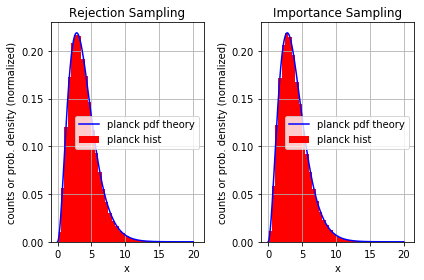

In [37]:
x_lin = np.linspace(0.001,20,1000) # we start at 0.001 (very close to zero and noticeable in the plot)
# because we want to avoid that python is unable to assign truths values elementwise.
plt.subplot(1,2,1)
plt.title('Rejection Sampling')
plt.hist(sampleRejection, bins=np.arange(start=0, stop=21, step=0.5), normed = True,
         histtype='bar', label='planck hist', color='r')
plt.plot(x_lin, planck(x_lin), 'b-', label='planck pdf theory')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('counts or prob. density (normalized)')
plt.subplot(1,2,2)
plt.title('Importance Sampling')
plt.hist(sampleImportance, bins=np.arange(start=0, stop=21, step=0.5), normed = True,
         histtype='bar', label='planck hist', color='r')
plt.plot(x_lin, planck(x_lin), 'b-', label='planck pdf theory')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('counts or prob. density (normalized)')
plt.tight_layout()
plt.show()

In [43]:
SETUP_CODE = '''
import numpy as np
from scipy import optimize
from scipy import integrate
from numpy import random
import matplotlib.pyplot as plt
import timeit
from __main__ import RejectionSampling
'''

TEST_CODE = ''' 
sampleRejection = []
sampleRejection, counter1 = RejectionSampling(sampleRejection, x_cut = 20, y_max = 0.218886470091)
'''
      
# timeit.repeat statement 
times = timeit.timeit(setup = SETUP_CODE, stmt = TEST_CODE, number = 5)
print(times)

3.547462114902885
